In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nnf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

torch.set_default_dtype(torch.float64)

In [2]:
def is_array(X):
    return isinstance(X, (list, tuple, np.ndarray))

In [3]:
degree = 3
K = np.array([i for i in range(degree)])
K_pt = torch.from_numpy(K)

def basis_cos(x):
    if is_array(x):
        return np.cos(np.outer(K, x))
    
    if torch.is_tensor(x):
        return torch.cos(torch.ger(K_pt, x))
    
    return np.cos(x * K)

def basis_sin(x):
    if is_array(x):
        return np.sin(np.outer(K, x))
    
    if torch.is_tensor(x):
        return torch.sin(torch.ger(K_pt, x))
    
    return np.cos(x * K)

class FourierFunction:
    
    def __init__(self, A, B):
        if len(A) != len(K) or len(B) != len(K):
            raise ValueError("Invalid input shape")
        
        self.A = A
        self.B = B
    
    def compute(self, X):
        return (self.A @ basis_cos(X)) + (self.B @ basis_sin(X))
    
    def derive1(self, X):
        return ((self.B * K) @ basis_cos(X)) - ((self.A * K) @ basis_sin(X))
    
    def derive2(self, X):
        return -((self.A * (K**2)) @ basis_cos(X)) - ((self.B * (K**2)) @ basis_sin(X))
    
    def derive3(self, X):
        return -((self.B * (K**3)) @ basis_cos(X)) + ((self.A * (K**3)) @ basis_sin(X))
    
    def derive4(self, X):
        return ((self.A * (K**4)) @ basis_cos(X)) + ((self.B * (K**4)) @ basis_sin(X))



In [4]:
def generate_coefficients(use_np):
    lim = 10
    sigma = 0.1
    a, b = -lim/sigma, +lim/sigma 
    A = sigma * truncnorm.rvs(a, b, size=degree)
    B = sigma * truncnorm.rvs(a, b, size=degree)
    if use_np:
        return A, B
    
    return torch.from_numpy(A), torch.from_numpy(B)

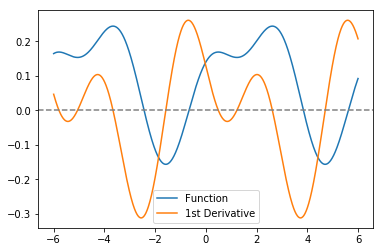

In [5]:
# Test FourierFunction and its derivatives
debug_func = True
X = np.linspace(-6, 6, 1000)
if debug_func:
    A, B = generate_coefficients(True)
    func = FourierFunction(A, B)
    plt.plot(X, func.compute(X), label="Function")
    plt.plot(X, func.derive1(X), label="1st Derivative")
    plt.axhline(color='gray', linestyle='--')
    plt.legend()
    plt.show()

In [9]:
class DerivativeNet(nn.Module):

    def __init__(self):
        super(DerivativeNet, self).__init__()
        self.fct1 = nn.Linear(1000, 2000)
        self.fct2 = nn.Linear(2000, 1000)

    def forward(self, x):
        x = torch.tanh(self.fct1(x))
        x = 10 * self.fct2(x)
        return x

In [14]:
net = DerivativeNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.000001)

In [15]:
for epoch in range(0, 3_000+1):
    A, B = generate_coefficients(True)
    func = FourierFunction(A, B)
    target = torch.from_numpy(func.derive2(X))
    Y = torch.from_numpy(func.compute(X))
    Y.requires_grad = True

    optimizer.zero_grad()
    output = net(Y)
    loss = criterion(output, target)
    loss.backward(Y)
        
    optimizer.step()
    if epoch % 500 == 0:
        print("Epoch "+str(epoch)+": "+("%.6f" % loss.data.item()))
    
    if epoch == 500 or epoch == 8000:
        for g in optimizer.param_groups:
            g['lr'] = g['lr'] / 10

Epoch 0: 0.140128
Epoch 500: 0.798380
Epoch 1000: 0.170753
Epoch 1500: 0.180753
Epoch 2000: 0.609142
Epoch 2500: 0.101793
Epoch 3000: 1.320458


<IPython.core.display.Javascript object>


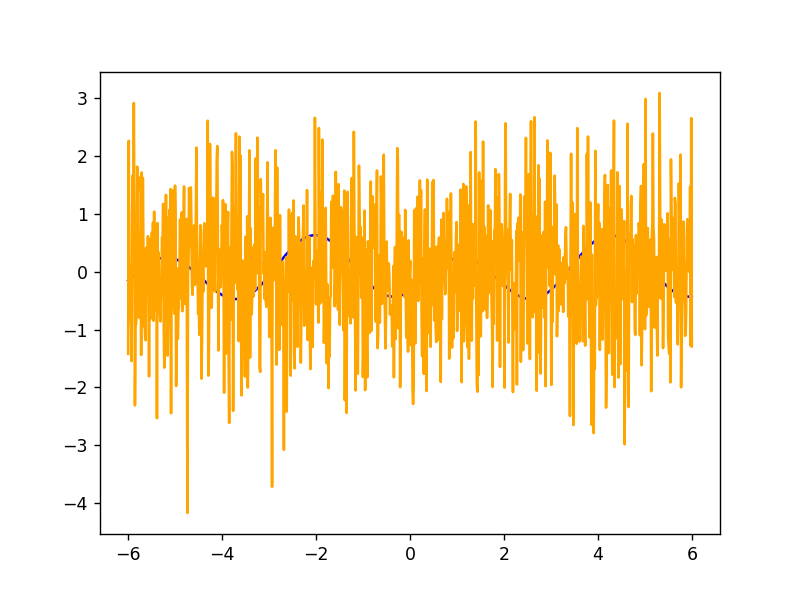

In [16]:
%matplotlib notebook

fig2 = plt.figure()
computed = net(torch.from_numpy(func.compute(X)))

plt.plot(X, func.derive2(X), color='blue')
plt.plot(X, computed.detach().numpy(), color='orange')
plt.show()

<IPython.core.display.Javascript object>


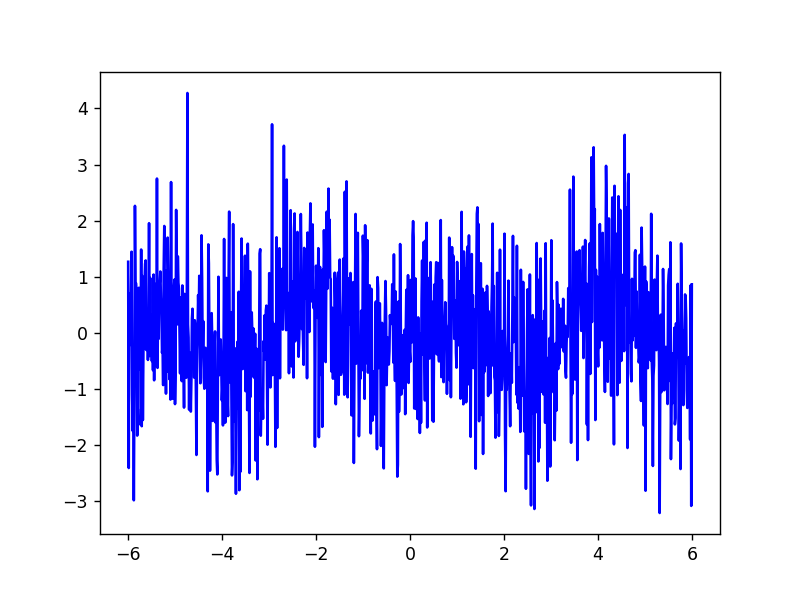

In [17]:
fig3 = plt.figure()
plt.plot(X, func.derive2(X) - computed.detach().numpy(), color='blue')
plt.show()